# 我国规范中的混凝土本构与OpenSees本构

## 1 简介

抗震研究领域常用软件OpenSees是一款由UC Berkeley和PEER共同开发的开源软件平台，具有非常突出的非线性动力计算能力，并且提供了丰富的材料本构（特别是混凝土材料）。同时，用户也可以根据需要对程序进行材料和单元模型、迭代算法等的二次开发。对于大多数用户而言，重新开发新的材料本构模型难度较大，通常都是直接使用软件提供的材料本构和单元模型进行计算分析。然而，OpenSees混凝土材料手册写得太过简略，网页端还不支持数学公式，看起来费劲。这里对OpenSees中的几种常用混凝土本构进行梳理。具体内容如下：

* 第二节对我国《混凝土结构设计规范》GB 50010 - 2010中混凝土的材料特性及单轴本构进行介绍；
* 第三节对约束混凝土的常用单轴本构——Mander模型进行介绍；
* 第四节对OpenSees中的几种常用本构进行梳理。

需要注意的是，这里所提到的材料本构均为狭义本构，及**单调荷载下的单轴应力 - 应变关系**，暂时不涉及往复荷载下的加卸载路径、受拉曲线原点偏移、裂缝闭合等问题的详细介绍。同时，在编写OpenSees中几种常用混凝土本构时，相关参数的输入取经验值，实际上可采用非线性拟合等方法得到参数的最优值，相关内容后期可能更新，也欢迎有了解的同行加入完善。

Jupyter Notebook中有关参考文献的插入目前还没有找到好的办法，这里将按先后顺序参考文献一并列出：

>1. 中华人民共和国住房和城乡建设部组织. 混凝土结构设计规范:GB 50010-2010. 混凝土结构设计规范：GB 50010-2010; 2014.
>2. 过镇海. 钢筋混凝土原理. 钢筋混凝土原理; 2013.
>3. Mander JB, Priestley MJN, Park R. Theoretical Stress‐Strain Model for Confined Concrete. Journal of Structural Engineering. 1988;114(8):1804-1826. doi:10.1061/(asce)0733-9445(1988)114:8(1804)
>4. Chang G, Mander JB. Seismic energy based fatigue damage analysis of bridge columns: Part I-Evaluation of seismic capacity. National Center for Earthquake Engineering Research Buffalo, NY; 1994.
>5. Stanton JF, McNiven HD. The development of a mathematical model to predict the flexural response of reinforced concrete beams to cyclic loads, using system identification. 1979. 
>5. Lee WK, Billington SL. Simulation and Performance-Based Earthquake Engineering Assessment of Self-Centering Post-Tensioned Concrete Bridge Systems. 2009;
>6. Popovics S. A numerical approach to the complete stress-strain curve of concrete. Cement and Concrete Research. 1973;3(5):583-599. doi:10.1016/0008-8846(73)90096-3
>7. 赵金钢, 杜斌, 占玉林, 赵凯. OpenSees中混凝土本构模型用于模拟结构滞回性能的对比. 桂林理工大学学报. 2017;37(1):9. 
>8. Waugh JD. Nonlinear analysis of T-shaped concrete walls subjected to multi-directional displacements. Iowa State University; 2009.
>9. Tsai WT. Uniaxial Compressional Stress‐Strain Relation of Concrete. Journal of Structural Engineering. 1988;114(9):2133-2136. doi:10.1061/(asce)0733-9445(1988)114:9(2133)
>10. Kolozvari K, Orakcal K, Wallace J. Shear-flexure interaction modeling for reinforced concrete structural walls and columns under reversed cyclic loading. Pacific Earthquake Engineering Research Center, University of California, Berkeley, PEER Report. 2015;(2015/12)

由于作者水平有限，该文档出现错误在所难免，还请读者批评指正。

联系方式：周迅 702135971@qq.com

### 版本更新

1. 2022.6.29

> 初始版本发布

## 2 混凝土材料特性及单轴本构

<style>
table
{
    margin: auto;
}
td
{
    text-align:center;
}
</style>


### 2.1 材料特性

**立方体抗压强度及其标准值**

为了确定混凝土的抗压强度，我国国标《普通混凝土力学性能试验方法》（GB/T 50081-2002）中规定：标准时间取边长为150mm的立方体，用钢模成型，经浇筑、振捣密实后静置一昼夜，试件拆模后放入标准养护室，即（20±3）℃，相对湿度>90%；28天龄期后取出试件，擦干表面水，置于试验机内，沿浇筑的垂直方向施加压力，以每秒0.3~0.5MPa的速度连续加载至试件破坏。试件的破坏荷载除以承压面积，即为混凝土的立方体抗压强度$f_{cu}$。立方体抗压强度标准值$f_{cu,k}$系指按标准方法制作、养护的边长为150mm的立方体试件，在28天或设计规定龄期以标准试验方法测得的具有95%保证率的抗压强度值。

**圆柱体抗压强度**

有些国家（如美国、日本）和国际学术组织（如CEB-FIP)规定以圆柱体为标准抗压试件，高300mm，直径150mm。测定的强度成为圆柱体抗压强度，以$f_c^{'}$表示。不同形状和尺寸试件的混凝土抗压强度相对值如下表。

<table>
    <caption>表2.1 不同形状和尺寸时间的混凝土抗压强度相对值</caption>
    <tr>
        <td rowspan="3">混凝土试件</td>
        <td colspan="3">立方体</td>
        <td colspan="5">圆柱体</td>
    </tr>
    <tr>
        <td colspan="3">边长/mm</td>
        <td colspan="5">强度等级</td>
    </tr>
    <tr>
        <td>200</td>
        <td>150</td>
        <td>150</td>
        <td>C20~C40</td>
        <td>C50</td>
        <td>C60</td>
        <td>C70</td>
        <td>C80</td>
    </tr>
    <tr>
        <td>抗压强度相对值</td>
        <td>0.95</td>
        <td>1</td>
        <td>1.05</td>
        <td>0.80</td>
        <td>0.83</td>
        <td>0.86</td>
        <td>0.875</td>
        <td>0.89</td>
    </tr>
</table>

**棱柱体抗压强度及其标准值**

为消除立方体试件两端局部应力和约束变形的影响，采用棱柱体试件进行抗压试验。棱柱体标准时间的尺寸取为150mm×150mm×300mm，时间的支座、养护、加载龄期和试验方法与立方体标准试验相同。试件的破坏荷载除以截面积，即为混凝土的棱柱体抗压强度$f_{c}$。棱柱体抗压强度标准值$f_{ck}$指按标准方法制作、养护的尺寸为150mm×150mm×300mm的棱柱体试件，在28天或设计规定龄期以标准试验方法测得的具有95%保证率的抗压强度值。

**混凝土的变异系数**

混凝土材料的变异系数$\delta_f$可按下表取用。

<table>
    <caption>表2.2 混凝土材料的变异系数</caption>
    <tr>
        <td>混凝土等级</td>
        <td>C25</td>
        <td>C30</td>
        <td>C35</td>
        <td>C40</td>
        <td>C45</td>
        <td>C50</td>
        <td>C55</td>
        <td>C60</td>
    </tr>
    <tr>
        <td>混规</td>
        <td>0.189</td>
        <td>0.172</td>
        <td>0.164</td>
        <td>0.156</td>
        <td>0.156</td>
        <td>0.149</td>
        <td>-</td>
        <td>0.41</td>
    </tr>
    <tr>
        <td>桥规</td>
        <td>0.16</td>
        <td>0.14</td>
        <td>0.13</td>
        <td>0.12</td>
        <td>0.12</td>
        <td>0.11</td>
        <td>0.11</td>
        <td>0.10</td>
    </tr>
</table>

**轴心抗压、抗拉强度标准值**

混凝土的强度标准值可由立方体抗压强度标准值$f_{cu,k}$经计算确定。其中轴心抗压强度标准值$f_{ck}$取值如下表。

<table>
    <caption>表2.3 不同等级混凝土轴心抗压强度标准值</caption>
    <tr>
        <td rowspan="2">强度</td>
        <td colspan="14">混凝土强度等级</td>
    </tr>
    <tr>
        <td>C15</td>
        <td>C20</td>
        <td>C25</td>
        <td>C30</td>
        <td>C35</td>
        <td>C40</td>
        <td>C45</td>
        <td>C50</td>
        <td>C55</td>
        <td>C60</td>
        <td>C65</td>
        <td>C70</td>
        <td>C75</td>
        <td>C80</td>
    </tr>
    <tr>
        <td>f_{ck}</td>
        <td>10.0</td>
        <td>13.4</td>
        <td>16.7</td>
        <td>20.1</td>
        <td>23.4</td>
        <td>26.8</td>
        <td>29.6</td>
        <td>32.4</td>
        <td>35.5</td>
        <td>38.5</td>
        <td>41.5</td>
        <td>44.5</td>
        <td>47.4</td>
        <td>50.2</td>
    </tr>
</table>

轴心抗拉强度标准值取值如下表。

<table>
    <caption>表2.4 不同等级混凝土轴心抗拉强度标准值</caption>
    <tr>
        <td rowspan="2">强度</td>
        <td colspan="14">混凝土强度等级</td>
    </tr>
    <tr>
        <td>C15</td>
        <td>C20</td>
        <td>C25</td>
        <td>C30</td>
        <td>C35</td>
        <td>C40</td>
        <td>C45</td>
        <td>C50</td>
        <td>C55</td>
        <td>C60</td>
        <td>C65</td>
        <td>C70</td>
        <td>C75</td>
        <td>C80</td>
    </tr>
    <tr>
        <td>f_{tk}</td>
        <td>1.27</td>
        <td>1.54</td>
        <td>1.78</td>
        <td>2.01</td>
        <td>2.20</td>
        <td>2.39</td>
        <td>2.51</td>
        <td>2.64</td>
        <td>2.74</td>
        <td>2.85</td>
        <td>2.93</td>
        <td>2.99</td>
        <td>3.05</td>
        <td>3.11</td>
    </tr>
</table>

混凝土受压和受拉的弹性模量$E_c$按下表采用。

<table>
    <caption>表2.5 不同等级混凝土弹性模量</caption>
    <tr>
        <td>混凝土等级</td>
        <td>C15</td>
        <td>C20</td>
        <td>C25</td>
        <td>C30</td>
        <td>C35</td>
        <td>C40</td>
        <td>C45</td>
        <td>C50</td>
        <td>C55</td>
        <td>C60</td>
        <td>C65</td>
        <td>C70</td>
        <td>C75</td>
        <td>C80</td>
    </tr>
    <tr>
        <td>E_c(GPa)</td>
        <td>22.0</td>
        <td>25.5</td>
        <td>28.0</td>
        <td>30.0</td>
        <td>31.5</td>
        <td>32.5</td>
        <td>33.5</td>
        <td>34.5</td>
        <td>35.5</td>
        <td>36.0</td>
        <td>36.5</td>
        <td>37.0</td>
        <td>37.5</td>
        <td>38.0</td>
    </tr>
</table>

混凝土剪切模量$G_c$取为$E_c$的0.4倍，泊松比取0.2。

### 2.2 混凝土单轴本构关系

混凝土单轴受压的应力-应变曲线可按下列公式确定：

$$
\sigma = (1 - d_c)E_c\epsilon \tag{2.1}
$$

$$
d_c = 
\left\{\begin{matrix} 
  1 - \displaystyle{\frac{\rho_cn}{n - 1 + x^n}} & x \leq 1\\  
  1 - \displaystyle{\frac{\rho_c}{\alpha_c(x - 1)^2 + x}} & x > 1
\end{matrix}\right. \tag{2.2}
$$

$$
\rho_c = \displaystyle{\frac{f_{c,r}}{E_c\epsilon_{c,r}}} \tag{2.3}
$$

$$
n = \displaystyle{\frac{E_c\epsilon_{c,r}}{E_c\epsilon_{c,r}-f_{c,r}}} \tag{2.4}
$$

$$
x = \displaystyle{\frac{\epsilon}{\epsilon_{c,r}}} \tag{2.5}
$$

其中，$f_{c,r}$为混凝土单轴抗压强度代表值。

<table>
<caption>表2.6 混凝土单轴受压应力－应变曲线的参数取值</caption>
    <tr>
        <td>f_{c,r}</td>
        <td>20</td>
        <td>25</td>
        <td>30</td>
        <td>35</td>
        <td>40</td>
        <td>45</td>
        <td>50</td>
        <td>55</td>
        <td>60</td>
        <td>65</td>
        <td>70</td>
        <td>75</td>
        <td>80</td>
    </tr>
    <tr>
        <td>\epsilon_{c,r}(10^{-6})</td>
        <td>1470</td>
        <td>1560</td>
        <td>1640</td>
        <td>1720</td>
        <td>1790</td>
        <td>1850</td>
        <td>1920</td>
        <td>1980</td>
        <td>2030</td>
        <td>2080</td>
        <td>2130</td>
        <td>2190</td>
        <td>2240</td>
    </tr>
    <tr>
        <td>\alpha_c</td>
        <td>0.74</td>
        <td>1.06</td>
        <td>1.36</td>
        <td>1.65</td>
        <td>1.94</td>
        <td>2.21</td>
        <td>2.48</td>
        <td>2.74</td>
        <td>3.00</td>
        <td>3.25</td>
        <td>3.50</td>
        <td>3.75</td>
        <td>3.99</td>
    </tr>
</table>

混凝土单轴受拉的应力-应变曲线可按下列公式确定：

$$
\sigma = (1 - d_t)E_c\epsilon \tag{2.6}
$$

$$
d_c = 
\left\{\begin{matrix} 
  1 - \rho_t [1.2-0.2x^5] & x \leq 1\\  
  1 - \displaystyle{\frac{\rho_t}{\alpha_t(x - 1)^{1.7} + x}} & x > 1
\end{matrix}\right. \tag{2.7}
$$

$$
\rho_t = \displaystyle{\frac{f_{t,r}}{E_c\epsilon_{t,r}}} \tag{2.8}
$$

$$
x = \displaystyle{\frac{\epsilon}{\epsilon_{t,r}}} \tag{2.9}
$$

其中，$f_{t,r}$为混凝土单轴抗拉强度代表值。

<table>
<caption>表2.7 混凝土单轴受拉应力－应变曲线的参数取值</caption>
    <tr>
        <td>f_{t,r}</td>
        <td>1.0</td>
        <td>1.5</td>
        <td>2.0</td>
        <td>2.5</td>
        <td>3.0</td>
        <td>3.5</td>
        <td>4.0</td>
    </tr>
    <tr>
        <td>\epsilon_{t,r}(10^{-6})</td>
        <td>65</td>
        <td>81</td>
        <td>95</td>
        <td>107</td>
        <td>118</td>
        <td>128</td>
        <td>137</td>
    </tr>
    <tr>
        <td>\alpha_t</td>
        <td>0.31</td>
        <td>0.70</td>
        <td>1.25</td>
        <td>1.95</td>
        <td>2.81</td>
        <td>3.82</td>
        <td>5.00</td>
    </tr>
</table>

由此得到受拉、受压全曲线如下。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 基本参数输入
# 为了和Mander能够合上，fcr得取fcp，即圆柱体抗压强度

fcuk = 40 # 立方体标准值 C40（MPa）
fcr = 32 # 抗压强度代表值，可取立方体强度、*抗压强度标准值*、抗压强度平均值等等（MPa）
ftr = 2.39 # 抗拉强度代表值，可取立方体强度、*抗拉强度标准值*、抗拉强度平均值等等（MPa）

In [3]:
xc = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
mc = np.array([25.5, 28.0, 30.0, 31.5, 32.5, 33.5, 34.5, 35.5, 36.0, 36.5, 37.0, 37.5, 38.0]) * 10**3
yc = np.array([1470, 1560, 1640, 1720, 1790, 1850, 1920, 1980, 2030, 2080, 2130, 2190, 2240]) * 10**(-6)
zc = np.array([0.74, 1.06, 1.36, 1.65, 1.94, 2.21, 2.48, 2.74, 3.00, 3.25, 3.50, 3.75, 3.99])

Ec = np.interp(fcuk, xc, mc) # 根据混规插值弹模（MPa）
epscr = np.interp(fcr, xc, yc) # 根据混规插值峰值压应力对应的应变
ac = np.interp(fcr,xc,zc) # 根据混规插值受压曲线形状参数

xt = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
yt = np.array([65, 81, 95, 107, 118, 128, 137]) * 10**(-6)
zt = np.array([0.31, 0.70, 1.25, 1.95, 2.81, 3.82, 5.00])

epstr = np.interp(ftr, xt, yt) # 根据混规插值峰值拉应力对应的应变
at = np.interp(ftr, xt, zt) # 根据混规插值受拉曲线形状参数

(0.0, 33.6)

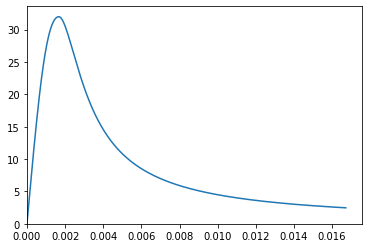

In [4]:
# 受压应力应变曲线计算

rhoc = fcr / Ec / epscr
n = Ec * epscr / (Ec * epscr - fcr)

# 上升段

xc1 = np.linspace(0, 1, 100, endpoint=False)
dc1 = 1 - rhoc * n / (n - 1 + xc1 ** n)
sc1 = (1 - dc1) * Ec * xc1 * epscr
ec1 = xc1 * epscr

# 下降段

xc2 = np.linspace(1, 10, 1000, endpoint=True)
dc2 = 1 - rhoc / (ac * (xc2 - 1)**2 + xc2)
sc2 = (1 - dc2) * Ec * xc2 * epscr
ec2 = xc2 * epscr

ec = np.concatenate((ec1, ec2)) # 上升段与下降段应变合成
sc = np.concatenate((sc1, sc2)) # 上升段与下降段应力合成

plt.plot(ec, sc)
plt.xlim(left = 0)
plt.ylim(bottom = 0)


(0.0, 2.5095)

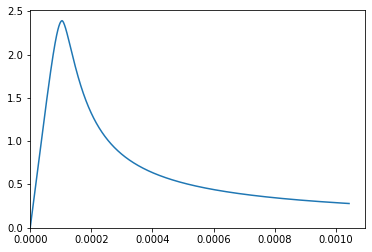

In [5]:
# 受拉应力应变曲线计算

rhot = ftr / Ec / epstr

# 上升段

xt1 = np.linspace(0, 1, 100, endpoint=False)
dt1 = 1 - rhot * (1.2 - 0.2 * xt1 ** 5)
st1 = (1 - dt1) * Ec * xt1 * epstr
et1 = xt1 * epstr

# 下降段

xt2 = np.linspace(1, 10, 1000, endpoint=True)
dt2 = 1 - rhot / (at * (xt2 - 1)**1.7 + xt2)
st2 = (1 - dt2) * Ec * xt2 * epstr
et2 = xt2 * epstr

et = np.concatenate((et1, et2)) # 上升段与下降段应变合成
st = np.concatenate((st1, st2)) # 上升段与下降段应力合成

plt.plot(et, st)
plt.xlim(left = 0)
plt.ylim(bottom = 0)

## 3 约束混凝土的Mander本构

对于约束混凝土的本构关系，国内外学者进行了很多的试验研究。其中，得到最广泛认可的是Mander本构，这一曲线适用于任何截面形状和约束水平，可用下式表示：

$$
f_c = \displaystyle{\frac{f_{cc}^{'} \cdot x \cdot r}{r - 1 + x^r}} \tag{3.1}
$$

其中，$f_{cc}^{'}$为约束混凝土的峰值压应力。

$$
x = \displaystyle{\frac{\epsilon_c}{\epsilon_{cc}}} \tag{3.2}
$$

其中，$\epsilon_c$为混凝土的纵向压应变，$\epsilon_{cc}$为峰值压应力$f_{cc}^{'}$所对应的应变。

$$
\epsilon_{cc} = \bigg [5 \bigg (\frac{f_{cc}^{'}}{f_{c}^{'}} - 1 \bigg ) + 1 \bigg ]\epsilon_{c0} \tag{3.3}
$$

其中，$f_{c}^{'}$、$\epsilon_{c0}$分别为无约束混凝土的圆柱体抗压强度及相应的纵向压应变。

$$
r = \displaystyle{\frac{E_c}{E_c - E_{sec}}} \tag{3.4}
$$

$$
E_c = 5000 \sqrt{f_{c}^{'}} \tag{3.5}
$$

$$
E_{sec} = \displaystyle{\frac{f_{cc}^{'}}{\epsilon_{cc}}} \tag{3.6}
$$

其中，各强度、模量的单位取MPa。

约束混凝土的峰值压应力$f_{cc}^{'}$分两种情况计算：
1. 圆形截面

    由于圆形截面水平方向上的约束应力相等，根据混凝土的三维本构，可以得到如下峰值压应力$f_{cc}^{'}$与有效横向约束应力的关系。

    $$
    f_{cc}^{'} = f_{c}^{'} \cdot \bigg (2.254 \sqrt{1 + \displaystyle{\frac{7.94f_l^{'}}{f_{c}^{'}}}} - 2\displaystyle{\frac{f_l^{'}}{f_{c}^{'}}} - 1.254 \bigg ) \tag{3.7}
    $$

    其中，$f_l^{'}$为有效横向约束应力。

    $$
    f_l^{'} = K_e\displaystyle{\frac{2f_{yh} \cdot A_{sp}}{D^{'} \cdot s}} \tag{3.8}
    $$

    其中，$K_e$为截面的有效约束系数，为有效约束核心混凝土面积与核心混凝土总面积之比，一般取0.95。或按下式进行计算。

    $$
    \left\{\begin{matrix} 
      K_e = \displaystyle{\frac{ \bigg (1 - \displaystyle{\frac {s'}{2d_s}} \bigg )}{1 - \rho_{cc}}} & 螺旋筋 \\
      K_e = \displaystyle{\frac{ \bigg (1 - \displaystyle{\frac {s'}{2d_s}} \bigg )^2}{1 - \rho_{cc}}} & 圆形箍筋
    \end{matrix}\right. \tag{3.9}
    $$
    
    $f_{yh}$、$A_{sp}$为箍筋的屈服强度和截面面积；$D^{'}$、$s$分别为`箍筋环`的直径和纵向间距。   


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# 基本参数输入

fcuk = 40 # 立方体标准值 C40（MPa）
fyh = 300 # 箍筋的屈服强度（MPa）
dsp = 12 # 箍筋直径（mm）
Dp = 1500 # 箍筋环直径（mm）
s = 50 # 箍筋间距（mm）

(0.0, 39.48063489650572)

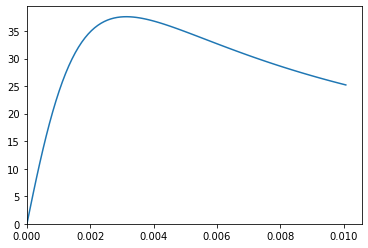

In [7]:
xc = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
yc = np.array([0.80, 0.80, 0.80, 0.80, 0.80, 0.815, 0.83, 0.845, 0.86, 0.8675, 0.875, 0.8825, 0.89])
zc = np.array([1470, 1560, 1640, 1720, 1790, 1850, 1920, 1980, 2030, 2080, 2130, 2190, 2240]) * 10**(-6)

fcp = np.interp(fcuk, xc, yc) * fcuk # 圆柱体抗压强度（MPa）
epsc0 = np.interp(fcp, xc, zc) # 根据混规插值出峰值应力对应的应变
Ec = 5000 * fcp**0.5 # 弹模（MPa）

Asp = 0.25 * np.pi * dsp**2 # 箍筋截面积mm^2

flp = 0.95 * 2 * fyh * Asp / Dp / s # 有效横向约束应力（MPa）
fccp = fcp * (2.254 * (1 + 7.94 * flp / fcp)**0.5 - 2 * flp / fcp - 1.254) # 约束后的峰值压应力（MPa）
epscc = epsc0 * (5 * (fccp / fcp - 1) + 1) # 约束后的峰值压应力对应的应变
Esec = fccp / epscc # 割线模量，用来定义骨架曲线（MPa）
r = Ec / (Ec - Esec) # 用来定义骨架曲线的形状参数

epscu = 0.004 + 1.4 * fyh * 0.09 * (4 * Asp / s / Dp) / fccp # 约束混凝土的极限压应变

x = np.linspace(0, epscu / epscc, 100)
msc = fccp * x * r / (r - 1 + x**r) # Mander本构骨架曲线的应力数据（MPa）
mec = x * epscc # Mander本构骨架曲线的应变数据

# plt.plot(ec,sc)
plt.plot(mec,msc)
plt.xlim(left = 0)
plt.ylim(bottom = 0)

# import pandas as pd
# import openpyxl

# out = pd.DataFrame(data=np.vstack((ec,sc)))
# out.to_excel("confined.xlsx")

2. 矩形截面

    矩形截面在两个主轴方向的有效约束应力分别为：

    $$
    f_{lx}^{'} = K_e \cdot \rho_{x} \cdot f_{yh}, \quad f_{ly}^{'} = K_e \cdot \rho_{y} \cdot f_{yh} \tag{3.10}
    $$

    其中，$\rho_{x} = A_{sx} / (s \cdot d_c)$，$\rho_{y} = A_{sy} / (s \cdot b_c)$，分别为箍筋在两个方向`x、y`的体积配箍率；$A_{sx}$、$A_{sy}$分别为沿`x、y`方向箍筋的总截面积；$d_c$、$b_c$分别为截面`y、x`方向的核心混凝土尺寸，按箍筋中心线计算；截面的有效约束系数$K_e$，一般矩形截面可取0.75，狭长截面可取0.6（Mander的原文献有具体公式）。由于矩形截面两个方向上的约束水平可能不同，因此可利用下图中约束应力和约束强度关系曲线，查出约束强度比。

    <div align="center">
    <img src="./confinement.png">
    </div>

    针对上图，可采用近似方程（式(3.11)~式(3.15)）计算约束强度。

    $$
    f_{cc}^{'} = f_{c}^{'} \cdot \bigg [1 + A \bar x \bigg(0.1 + \displaystyle{\frac {0.9}{1 + B \bar x}} \bigg) \bigg ] \tag{3.11}
    $$

    其中，

    $$
    \bar x = \displaystyle{\frac {f_{lx}^{'} + f_{ly}^{'}}{2f_{c}^{'}}} \tag{3.12}
    $$

    $$
    r = \displaystyle{\frac {f_{lx}^{'}}{f_{ly}^{'}}}, \quad f_{lx}^{'} \leq f_{ly}^{'} \tag{3.13}
    $$

    $$
    A = 6.8886-(0.6069+17.275r)e^{-4.989r} \tag{3.14}
    $$

    $$
    B = \displaystyle{\frac {4.5}{\displaystyle{\frac {5}{A}}(0.9849-0.6306e^{-3.8939r})-0.1}} - 5 \tag{3.15}
    $$

约束混凝土的极限压应变$\epsilon_{cu}$，定义为横向约束箍筋开始发生断裂时的混凝土压应变，可由下式保守估计：
$$
\epsilon_{cu} = 0.004 + \displaystyle{\frac{1.4\rho_s \cdot f_{yh} \cdot \epsilon_{su}}{f_{cc}^{'}}} \tag{3.16}
$$

其中，$\epsilon_{su}$为箍筋在最大拉应力时的应变（一般取为0.09）；$\rho_s$为箍筋的体积配箍率，对于矩形截面有$\rho_s = \rho_{x} + \rho_{y}$；$f_{cc}^{'}$为约束混凝土的峰值压应力；$f_{yh}$为约束箍筋的最大拉应力。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# 基本参数输入

fcuk = 40 # 立方体标准值 C40（MPa）
fyh = 300 # 箍筋的屈服强度（MPa）
dsp = 12 # 箍筋直径（mm）
dc = 2480 # 核心混凝土尺寸1（mm）
bc = 1680 # 核心混凝土尺寸2（mm）
n1 = 7 # 垂直于1方向的箍筋根数
n2 = 6 # 垂直于2方向的箍筋根数
s = 100 # 箍筋间距（mm）

(0.0, 38.97488427197577)

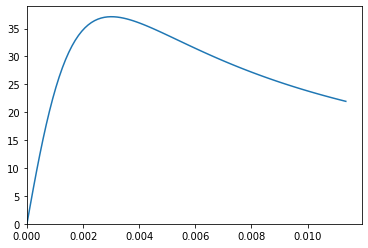

In [9]:
xc = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
yc = np.array([0.80, 0.80, 0.80, 0.80, 0.80, 0.815, 0.83, 0.845, 0.86, 0.8675, 0.875, 0.8825, 0.89])
zc = np.array([1470, 1560, 1640, 1720, 1790, 1850, 1920, 1980, 2030, 2080, 2130, 2190, 2240]) * 10**(-6)

fcp = np.interp(fcuk, xc, yc) * fcuk # 圆柱体抗压强度（MPa）
epsc0 = np.interp(fcp, xc, zc) # 根据混规插值出峰值应力对应的应变
Ec = 5000 * fcp**0.5 # 弹模（MPa）

Asp = 0.25 * np.pi * dsp**2 # 箍筋截面积mm^2

flxp = 0.75 * Asp * n1 / s / dc * fyh # 方向1上的横向约束应力（MPa）
flyp = 0.75 * Asp * n2 / s / bc * fyh # 方向2上的横向约束应力（MPa）

xbar = (flxp + flyp) / 2 / fcp
r = np.min([flxp, flyp]) / np.max([flxp, flyp])
A = 6.8886 - (0.6069 + 17.275 * r) * np.exp(-4.989 * r)
B = 4.5 / (5 / A * (0.9849 - 0.6306 * np.exp(-3.8939 * r)) - 0.1) - 5

fccp = fcp * (1 + A * xbar * (0.1 + 0.9 / (1 + B * xbar))) # 约束后的峰值压应力（MPa）
epscc = epsc0 * (5 * (fccp / fcp - 1) + 1) # 约束后的峰值压应力对应的应变
Esec = fccp / epscc # 割线模量，用来定义骨架曲线（MPa）
r = Ec / (Ec - Esec) # 用来定义骨架曲线的形状参数

epscu = 0.004 + 1.4 * fyh * 0.09 * (Asp * n1 / s / dc + Asp * n2 / s / bc) / fccp # 约束混凝土的极限压应变

x = np.linspace(0, epscu / epscc, 100)
msc = fccp * x * r / (r - 1 + x**r) # Mander本构骨架曲线的应力数据（MPa）
mec = x * epscc # Mander本构骨架曲线的应变数据

# plt.plot(ec,sc)
plt.plot(mec,msc)
plt.xlim(left = 0)
plt.ylim(bottom = 0)


## 4 OpenSees中常见的混凝土本构及相关取值

### 4.1 Concrete01

<div align="center">
<img src="./Concrete01.gif">
</div>

Concrete01仅考虑混凝土的受压，是OpenSees中最简单的混凝土本构。模型采用了单轴的Kent-Scott-Park本构模型模型由上升段和下降的二折线组成。在OpenSees中的命令为

```OpenSees
uniaxialMaterial Concrete01 $matTag $fpc $epsc0 $fpcu $epsU

$matTag	integer tag identifying material
$fpc	concrete compressive strength at 28 days (compression is negative)*
$epsc0	concrete strain at maximum strength*
$fpcu	concrete crushing strength *
$epsU	concrete strain at crushing strength*
```

模型的上升段采用Hognestad的二次式：
$$
y = 2x - x^2 \tag{4.1}
$$

其中$x$和$y$为无量纲坐标。

$$
x = \displaystyle{\frac{\epsilon}{\epsilon_{c0}}}, \quad y = \displaystyle{\frac{\sigma}{f^{'}_{c}}} \tag{4.2}
$$

对二次式求导可得到初始弹性模量为$2f^{'}_{c}/\epsilon_{c0}$。模型的下降段采用二折线，即线性下降至破碎强度$f^{'}_{cu}$，此时对应的应变为$\epsilon_{u}$；超过此应变后为水平线。Concrete01模型简单，计算速度快价格低，收到了大部分研究者的青睐。经过比较，通过调整模型参数，Concrete01能够很好地拟合《混凝土结构设计规范》GB 50010 - 2010中无约束混凝土的单轴本构关系；但是对于Mander约束本构，Concrete01的效果较一般（仅仅是相对无约束而言）。然而，该本构也或多或少存在着一定的缺陷：


1. 没有受拉行为。虽然主流观点认为结构分析时可忽略混凝土的受拉特性；同时混凝土结构本身带裂缝工作，在地震来临之前裂缝已经产生了，因此可以不考虑混凝土的受拉行为。然而是否模拟受拉还是需要视情况而定。
2. 由于不考虑混凝土材料开裂后裂缝的提前闭合（由于裂缝被压碎后的材料碎屑填满），采用Concrete01会导致结构的力-位移曲线出现“零”刚度的问题。这一问题虽然不会对结构最大位移响应产生明显影响，但是会出现严重损伤的结构残余位移偏小甚至为0的情况。（本质上是由于Concrete01采用了不符合实际的加卸载准则。但该准则内置在OpenSees中无法修改，如果残余位移是关注的重点，则应采用后面几种高级材料（如ConcreteCM）或重新写程序（如Concrete01withSITC)。)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# 基本参数输入

fpc = 32
epsc0 = 0.003
fpcu = 6.4
epsu = 0.008

(0.0, 33.6)

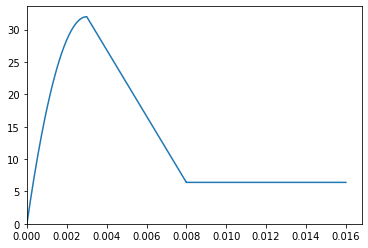

In [11]:
# 上升段

c1e1 = np.linspace(0, 1, 100) * epsc0
c1s1 = (2 * np.linspace(0, 1, 100) - np.linspace(0, 1, 100)**2) * fpc

# 下降段+水平线

c1e2 = np.linspace(1, epsu / epsc0, 100) * epsc0
c1s2 = (fpcu - fpc) / (epsu - epsc0) * (c1e2 - epsc0) + fpc
c1e3 = np.linspace(epsu / epsc0, 2 * epsu / epsc0, 100) * epsc0
c1s3 = np.ones(100) * fpcu

c1e = np.concatenate((c1e1, c1e2, c1e3))
c1s = np.concatenate((c1s1, c1s2, c1s3))

plt.plot(c1e, c1s)
# plt.plot(mec,msc)
plt.xlim(left = 0)
plt.ylim(bottom = 0)

### 4.2 Concrete02

<div align="center">
<img src="./Concrete02.jpg">
</div>

Concrete02受压部分与Concrete01相同因此不再赘述，同时Concrete02还考虑了混凝土的受拉部分，是OpenSees中次简单的混凝土本构。其命令如下：

```OpenSees
uniaxialMaterial Concrete02 $matTag $fpc $epsc0 $fpcu $epsU $lambda $ft $Ets

$matTag	integer tag identifying material
$fpc	concrete compressive strength at 28 days (compression is negative)*
$epsc0	concrete strain at maximum strength*
$fpcu	concrete crushing strength *
$epsU	concrete strain at crushing strength*
$lambda	ratio between unloading slope at $epscu and initial slope
$ft	tensile strength
$Ets	tension softening stiffness (absolute value) (slope of the linear tension softening branch)
```

Concrete02在考虑混凝土受拉时，上升段和下降段均采用线性模型简化。其中上升段斜率$2f^{'}_{c}/\epsilon_{c0}$，峰值强度$f_t$；下降段斜率为$E_{ts}$。Concrete02虽然在Concrete01的基础上考虑了混凝土的受拉，但是由于受拉部分的模型太过于简单，因此与《混凝土结构设计规范》GB 50010 - 2010中混凝土受拉本构的拟合效果并不好：

1. 上升段采用常刚度而非变刚度，并且采用了受压侧的初始刚度，因此低估了混凝土受拉峰值应力所对应的应变；
2. 线性下降段过于简化。（相比而言，Concrete04采用了指数下降模型，更符合实际。）

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# 基本参数输入

fpc = 32
epsc0 = 0.003135
fpcu = 25
epsu = 0.01

ft = 2.39
Ets = 0.3 * 2 * fpc / epsc0 # 0.6可调整

(0.0, 2.5095)

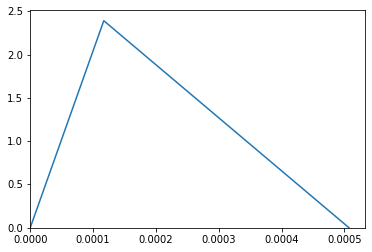

In [14]:
# 上升段

c2e1 = np.linspace(0, ft / (2 * fpc / epsc0), 100)
c2s1 = c2e1 * (2 * fpc / epsc0)

# 下降段

c2e2 = np.linspace(ft / (2 * fpc / epsc0), ft / (2 * fpc / epsc0) + ft / Ets, 100)
c2s2 = -Ets * (c2e2 - ft / (2 * fpc / epsc0)) + ft

c2e = np.concatenate((c2e1, c2e2))
c2s = np.concatenate((c2s1, c2s2))

plt.plot(c2e, c2s)
# plt.plot(et,st)
plt.xlim(left = 0)
plt.ylim(bottom = 0)

### 4.3 Concrete04

<div align="center">
<img src="./Concrete04.png">
</div>

Concrete04考虑了混凝土的受拉、受压行为。其中，受压行为采用了Popovics混凝土本构，该本构是描述混凝土单轴受压行为最成功的模型之一。实际上，Mander约束混凝土本构就是在Popovics本构的基础上发展而来的，而无约束混凝土本构就是Popovics本构。

$$
\displaystyle{\frac{\sigma}{f_{c}}} = \displaystyle{\frac{\bigg(\displaystyle{\frac{\epsilon}{\epsilon_{c}}}\bigg) \cdot r}{r - 1 + \bigg(\displaystyle{\frac{\epsilon}{\epsilon_{c}}}\bigg)^r}} \tag{4.3}
$$

其中，$r = {E_c}/(E_c - E_{sec})$，$E_{sec} = {f_{c}^{'}}/{\epsilon_{c}}$。

受拉行为采用了线性上升、指数下降模型，与实际受拉行为更为贴近。其中指数下降段的数学模型如下：

$$
\sigma = f_t \cdot \beta^{\bigg(\displaystyle{\frac{\epsilon - {f_{ct}}/{E_c}}{\epsilon_{tu} - {f_{ct}}/{E_c}}}\bigg)} \tag{4.4}
$$

Concrete04在OpenSees中的命令如下：

```opensees
uniaxialMaterial Concrete04 $matTag $fc $ec $ecu $Ec <$fct $etu> <$beta>

$matTag	integer tag identifying material
$fc	floating point values defining concrete compressive strength at 28 days (compression is negative)*
$ec	floating point values defining concrete strain at maximum strength*
$ecu	floating point values defining concrete strain at crushing strength*
$Ec	floating point values defining initial stiffness**
$fct	floating point value defining the maximum tensile strength of concrete
$etu	floating point value defining ultimate tensile strain of concrete
$beta	loating point value defining the exponential curve parameter to define the residual stress (as a factor of $ft) at $etu
```

Concrete04受拉本构的上升段仍然采用常刚度而非变刚度，并且采用了受压侧的初始刚度，因此低估了混凝土受拉峰值应力所对应的应变。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# 基本参数输入

fc = 32
ec = 0.001672
ecu = 0.004
Ec = 5000 * fc**0.5 # 弹模用这个值就和Mander完全一样

fct = 2.39
etu = 6 * fct / Ec # 系数可调
beta = 0.15 # 可调

(0.0, 2.5095)

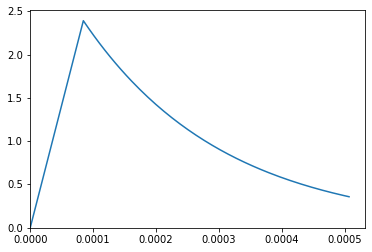

In [17]:
c4e1 = np.linspace(0, fct / Ec, 100)
c4s1 = c4e1 * Ec

c4e2 = np.linspace(fct / Ec, etu, 100)
c4s2 = fct * beta**((c4e2 - fct / Ec) / (etu - fct / Ec))

c4e = np.concatenate((c4e1, c4e2))
c4s = np.concatenate((c4s1, c4s2))

plt.plot(c4e, c4s)
# plt.plot(et,st)
plt.xlim(left = 0)
plt.ylim(bottom = 0)

### 4.4 Concrete06

主要用以模拟薄膜单元的力学性能，貌似不常用，这里先留个位置。

### 4.5 Concrete07

<div align="center">
<img src="./Concrete07.png">
</div>

Concrete07模型基于Chang - Mander本构。为了提高数值稳定性，Waugh对Chang - Mander本构的加卸载准则进行了调整，用三折线取代了原本的连续函数。该模型形式复杂计算用时长，但考虑因素全面。其受拉、受压骨架曲线的数学形式相同，均采用了Tsai提出的广义Popovics曲线，仅参数取值不同。

$$
y = \displaystyle{\frac {mx}{1 + \bigg( m - \displaystyle{\frac {n}{n - 1}} \bigg) x + \displaystyle{\frac {x^n}{n - 1}}}} \tag{4.5}
$$

其中，$m = E_c/E_{sec}$控制曲线上升段的倾斜程度；$n$则控制下降段的倾斜程度。可以看到如果将$m$取为$n/(n-1)$，式(4.4)则退化为式(4.2)。因此，该本构又被称为Popovics曲线的广义形式。对于无约束混凝土，模型中的相关参数取值可参考：

$$
\epsilon_c = \displaystyle{\frac {f_c^{1/4}}{1152.7}} \tag{4.6}
$$

$$
E_c = 8200f_c^{3/8} \tag{4.7}
$$

$$
f_t = 0.62f_c^{1/2} \tag{4.8}
$$

$$
\epsilon_t = \displaystyle{\frac {2f_t}{E_c}} \tag{4.9}
$$

$$
n = \displaystyle{\frac {f_c}{5.2}} - 1.9 \tag{4.10}
$$

同时由式(4.4)可见，即便$x \to \infty$时，$y$仍然大于零。而实际情况为，保护层混凝土受压（受拉）达到一定应变$\epsilon_{sp}(\epsilon_{crk})$时将会剥落。因此对于无约束混凝土，Concrete07本构认为当应变超过$x_n * \epsilon_c(x_p * \epsilon_t)$时，混凝土的应力 - 应变曲线将会直线下降至$(\epsilon_{sp}, 0)\big((\epsilon_{crk}, 0)\big)$。相关参数取值为：

$$
x_n = 2.3 \tag{4.11}
$$


$$
\epsilon_{sp} = x_n * \epsilon_c * \bigg[ 1 - \displaystyle{\frac {1+(m_c-n/(n-1))x_n+x_n^n/(n-1)}{1-x_n^n}} \bigg] \tag{4.12}
$$

$$
x_p = 2 \tag{4.13}
$$

$$
\epsilon_{crk} = x_p * \epsilon_t * \bigg[ 1 - \displaystyle{\frac {1+(m_t-n/(n-1))x_p+x_p^n/(n-1)}{1-x_p^n}} \bigg] \tag{4.14}
$$

Concrete07在OpenSees中的命令如下：

```opensees
uniaxialMaterial Concrete07 $matTag $fc $ec $Ec $ft $et $xp $xn $r

$matTag	integer tag identifying material
$fc	concrete compressive strength (compression is negative)*
$ec	concrete strain at maximum compressive strength*
$Ec	Initial Elastic modulus of the concrete
$ft	tensile strength of concrete (tension is positive)
$et	tensile strain at max tensile strength of concrete
$xp	Non-dimensional term that defines the strain at which the straight line descent begins in tension
$xn	Non-dimensional term that defines the strain at which the straight line descent begins in compression
$r	Parameter that controls the nonlinear descending branch
```

其中最后一个参数$r$，即为式(4.4)中的$n$。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# 基本参数输入

fc = 32 # 圆柱体抗压强度(MPa)；为使n大于1，fc至少应大于15.08，因此该本构对于低强度混凝土并不适用
epsc = 0.001672 # 建议值 fc**(1/4) / 1152.7，但和国标对不上，这里先用国标的值
Ec = 32500 # 建议值 8200 * fc**(3/8)，但和国标对不上，这里先用国标的值
ft = 2.39 # 建议值 0.62 * fc**(1/2)，但和国标对不上，这里先用国标的值
epst = 0.00010436 # 建议值 2 * ft / Ec，但和国标对不上，这里先用国标的值
n = fc / 5.2 - 1.9

xn = 2.3
xp = 2

(0.0, 33.59995705033611)

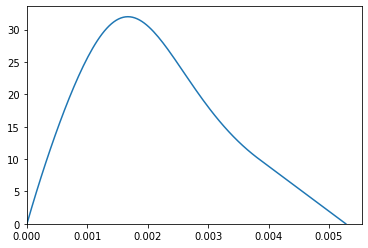

In [20]:
# 受压部分
# 广义Popovics曲线

Esecc = fc / epsc
mc = Ec / Esecc

c7e1c = np.linspace(0, xn, 100) * epsc
c7s1c = fc * (mc * np.linspace(0, xn, 100) / (1 + (mc - n/(n-1)) * np.linspace(0, xn, 100) + np.linspace(0, xn, 100)**n /(n-1)))

# 线性下降

esp = xn * epsc * (1 - (1+(mc-n/(n-1))*xn+xn**n/(n-1))/(1-xn**n))
c7e2c = np.linspace(xn, esp / epsc, 100) * epsc
c7s2c = np.linspace(c7s1c[-1], 0, 100)

c7ec = np.concatenate((c7e1c, c7e2c))
c7sc = np.concatenate((c7s1c, c7s2c))

plt.plot(c7ec, c7sc)
# plt.plot(ec,sc)
plt.xlim(left = 0)
plt.ylim(bottom = 0)

(0.0, 2.50932200231791)

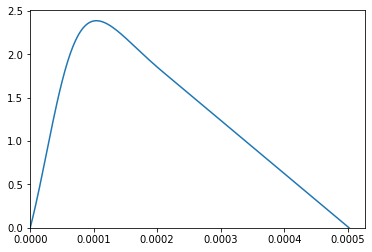

In [25]:
# 受拉部分
# 广义Popovics曲线

Esect = ft / epst
mt = Ec / Esect

c7e1t = np.linspace(0, xp, 100) * epst
c7s1t = ft * (mt * np.linspace(0, xp, 100) / (1 + (mt - n/(n-1)) * np.linspace(0, xp, 100) + np.linspace(0, xp, 100)**n /(n-1)))

# 线性下降

ecrk = xp * epst * (1 - (1+(mt-n/(n-1))*xp+xp**n/(n-1))/(1-xp**n))
c7e2t = np.linspace(xp, ecrk / epst, 100) * epst
c7s2t = np.linspace(c7s1t[-1], 0, 100)

c7et = np.concatenate((c7e1t, c7e2t))
c7st = np.concatenate((c7s1t, c7s2t))

plt.plot(c7et, c7st)
# plt.plot(et,st)
plt.xlim(left = 0)
plt.ylim(bottom = 0)

对于约束混凝土受压本构，则采用Mander模型对峰值应力$f_c$，及其对应的应变$\epsilon_c$进行调整（见式(3.3)~式(3.15)）。同时取。与Mander模型不同的是，Concrete07建议约束混凝土的极限压应变$\epsilon_{cu}$取大值，即$x_n$取大值（30）。而约束混凝土受拉本构保持不变。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# 基本参数输入

fcuk = 40 # 立方体标准值 C40（MPa）
fyh = 300 # 箍筋的屈服强度（MPa）
dsp = 12 # 箍筋直径（mm）
Dp = 1500 # 箍筋环直径（mm）
s = 50 # 箍筋间距（mm）

xc = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
yc = np.array([0.80, 0.80, 0.80, 0.80, 0.80, 0.815, 0.83, 0.845, 0.86, 0.8675, 0.875, 0.8825, 0.89])
zc = np.array([1470, 1560, 1640, 1720, 1790, 1850, 1920, 1980, 2030, 2080, 2130, 2190, 2240]) * 10**(-6)

fc = np.interp(fcuk, xc, yc) * fcuk # 圆柱体抗压强度（MPa）
epsc0 = np.interp(fc, xc, zc) # 根据混规插值出峰值应力对应的应变
Ec = 5000 * fc**0.5 # 弹模（MPa）

Asp = 0.25 * np.pi * dsp**2 # 箍筋截面积mm^2

flp = 0.95 * 2 * fyh * Asp / Dp / s # 有效横向约束应力（MPa）
fcc = fc * (2.254 * (1 + 7.94 * flp / fc)**0.5 - 2 * flp / fc - 1.254) # 约束后的峰值压应力（MPa）
epscc = epsc0 * (5 * (fcc / fc - 1) + 1) # 约束后的峰值压应力对应的应变

xn = 30

(0.0, 39.479821805266326)

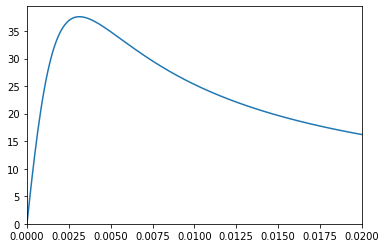

In [24]:
# 受压部分
# 广义Popovics曲线

Eseccc = fcc / epscc
mcc = Ec / Eseccc
n = mcc/(mcc-1)

c7e1cc = np.linspace(0, xn, 1000) * epscc
c7s1cc = fcc * (mcc * np.linspace(0, xn, 1000) / (1 + (mcc - n/(n-1)) * np.linspace(0, xn, 1000) + np.linspace(0, xn, 1000)**n /(n-1)))

# 线性下降

espc = xn * epscc * (1 - (1+(mcc-n/(n-1))*xn+xn**n/(n-1))/(1-xn**n))
c7e2cc = np.linspace(xn, espc / epscc, 100) * epscc
c7s2cc = np.linspace(c7s1cc[-1], 0, 100)

c7ecc = np.concatenate((c7e1cc, c7e2cc))
c7scc = np.concatenate((c7s1cc, c7s2cc))

plt.plot(c7ecc, c7scc)
# plt.plot(mec,msc)
plt.xlim(left = 0)
plt.xlim(right = 0.02)
plt.ylim(bottom = 0)

### 4.6 ConcreteCM

<div align="center">
<img src="./ConcreteCM.png">
</div>

ConcreteCM模型依然基于Chang - Mander本构，但该模型与Chang - Mander模型完全一致，不像Concrete07对原本构进行了简化。该模型形式复杂计算用时长，但考虑因素全面。其受拉、受压骨架曲线的数学形式相同，均采用了Tsai提出的广义Popovics曲线，仅参数取值不同。

ConcreteCM在OpenSees中的命令如下：

```opensees
uniaxialMaterial ConcreteCM $mattag $fpcc $epcc $Ec $rc $xcrn $ft $et $rt $xcrp <-GapClose $gap>

$mattag	Unique uniaxialMaterial tag
$fpcc	Compressive strength (f'c)
$epcc	Strain at compressive strength (<math>\epsilon</math>'c)
$Ec	Initial tangent modulus (Ec)
$rc	Shape parameter in Tsai’s equation defined for compression (rc)
$xcrn	Non-dimensional critical strain on compression envelope (<math>\epsilon</math>-cr, where the envelope curve starts following a straight line)
$ft	Tensile strength (ft)
$et	Strain at tensile strength (<math>\epsilon</math>t)
$rt	Shape parameter in Tsai’s equation defined for tension (rt)
$xcrp	Non-dimensional critical strain on tension envelope (<math>\epsilon</math>+cr, where the envelope curve starts following a straight line – large value [e.g., 10000] recommended when tension stiffening is considered)
<-GapClose $gap>	gap = 0, less gradual gap closure (default); gap = 1, more gradual gap closure
```

其中参数$r_c$，即为式(4.4)中的$n$。